2025-07-27 21:29:00.539669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 21:29:00.539758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 21:29:00.541164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 21:29:00.549587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 21:29:01.448219: W tensorflow/compiler/tf2

2025-07-27 21:29:02.519509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14409 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:41:00.0, compute capability: 8.6


Epoch 1/100


2025-07-27 21:29:05.273422: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-07-27 21:29:07.043753: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c13119b0ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-27 21:29:07.043809: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-07-27 21:29:07.050556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753651747.174768     256 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


205/205 [==============================] - 6s 8ms/step - loss: 28901.8418 - val_loss: 14273.5586
Epoch 2/100
205/205 [==============================] - 1s 6ms/step - loss: 3919.1416 - val_loss: 13547.5703
Epoch 3/100
205/205 [==============================] - 1s 6ms/step - loss: 3360.0764 - val_loss: 13403.8203
Epoch 4/100
205/205 [==============================] - 1s 6ms/step - loss: 3118.0137 - val_loss: 12792.8281
Epoch 5/100
205/205 [==============================] - 1s 6ms/step - loss: 2996.6003 - val_loss: 12995.9932
Epoch 6/100
205/205 [==============================] - 1s 6ms/step - loss: 2897.1274 - val_loss: 12260.4658
Epoch 7/100
205/205 [==============================] - 1s 6ms/step - loss: 2796.2136 - val_loss: 12768.6260
Epoch 8/100
205/205 [==============================] - 1s 5ms/step - loss: 2774.3982 - val_loss: 12459.9717
Epoch 9/100
205/205 [==============================] - 1s 6ms/step - loss: 2763.9412 - val_loss: 11309.2539
Epoch 10/100
205/205 [=================

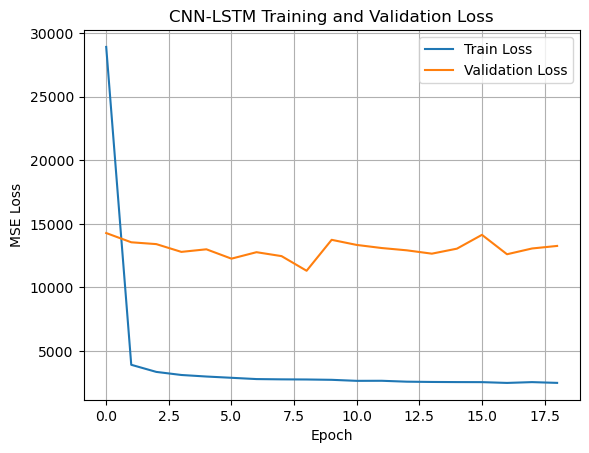

44/44 [==============================] - 0s 2ms/step

 Validation Set Evaluation:
   ➤ MAE:  67.80
   ➤ RMSE: 106.34
   ➤ R²:   0.3439
44/44 [==============================] - 0s 2ms/step

 Test Set Evaluation:
   ➤ MAE:  100.75
   ➤ RMSE: 129.06
   ➤ R²:   -0.2338
44/44 [==============================] - 0s 1ms/step


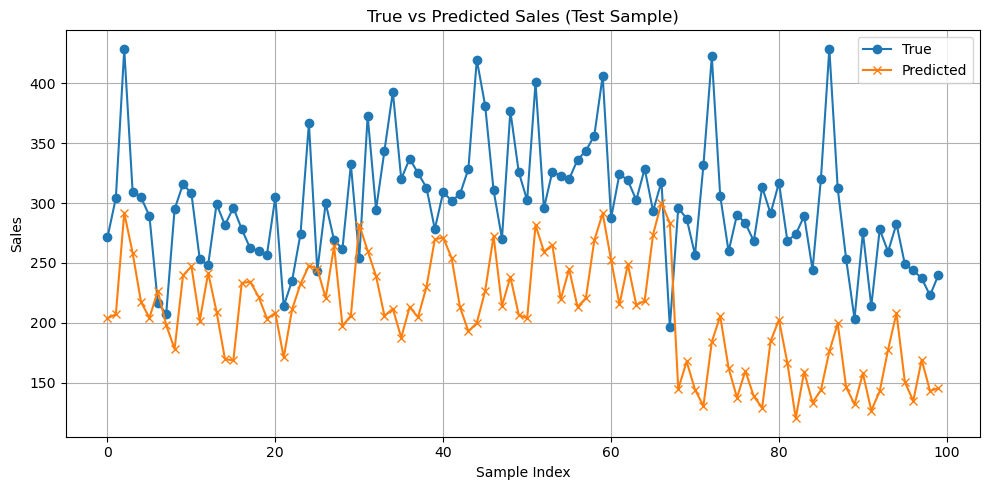

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset
df = pd.read_csv("bakery_training_dataset.csv")

# Preprocess Data
# Drop non-numeric or redundant columns
unused_cols = ["Datum", "Warengruppe_Name", "Wochentag", "Jahreszeit"]
df.drop(columns=unused_cols, inplace=True, errors='ignore')

# Target and features
target = "Umsatz"
features = df.columns[df.columns != target].tolist()

# Split data
total_len = len(df)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)

train = df[:train_size]
val = df[train_size:train_size + val_size]
test = df[train_size + val_size:]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN-LSTM [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build CNN-LSTM Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN-LSTM Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Function
def evaluate_model(model, X, y, label="Test"):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    print(f"\n {label} Set Evaluation:")
    print(f"   ➤ MAE:  {mae:.2f}")
    print(f"   ➤ RMSE: {rmse:.2f}")
    print(f"   ➤ R²:   {r2:.4f}")
    return y_pred

# Evaluate
_ = evaluate_model(model, X_val_reshaped, y_val, label="Validation")
_ = evaluate_model(model, X_test_reshaped, y_test, label="Test")

# Plot True vs Predicted on Test Set
y_test_pred = model.predict(X_test_reshaped)
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='True', marker='o')
plt.plot(y_test_pred[:100], label='Predicted', marker='x')
plt.title("True vs Predicted Sales (Test Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
